<a href="https://colab.research.google.com/github/hassen8/emotion_recognition_bias_auditing/blob/master/notebooks/deepface_on_RAF_GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to drive then download, unzip the dataset then copy the label file

In [4]:
#before this step make sure you add shortcuts of the EmoLabel and Image folders to your Drive
from google.colab import drive
drive.mount('/content/drive/')

# Then access files like:
# /content/drive/MyDrive/your_dataset.csv

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# use the paths of your own drive
!unzip /content/drive/MyDrive/Image/aligned.zip

Streaming output truncated to the last 5000 lines.
  inflating: aligned/train_07272_aligned.jpg  
  inflating: aligned/train_07273_aligned.jpg  
  inflating: aligned/train_07274_aligned.jpg  
  inflating: aligned/train_07275_aligned.jpg  
  inflating: aligned/train_07276_aligned.jpg  
  inflating: aligned/train_07277_aligned.jpg  
  inflating: aligned/train_07278_aligned.jpg  
  inflating: aligned/train_07279_aligned.jpg  
  inflating: aligned/train_07280_aligned.jpg  
  inflating: aligned/train_07281_aligned.jpg  
  inflating: aligned/train_07282_aligned.jpg  
  inflating: aligned/train_07283_aligned.jpg  
  inflating: aligned/train_07284_aligned.jpg  
  inflating: aligned/train_07285_aligned.jpg  
  inflating: aligned/train_07286_aligned.jpg  
  inflating: aligned/train_07287_aligned.jpg  
  inflating: aligned/train_07288_aligned.jpg  
  inflating: aligned/train_07289_aligned.jpg  
  inflating: aligned/train_07290_aligned.jpg  
  inflating: aligned/train_07291_aligned.jpg  
  inflati

In [6]:
# same here, use your own path
!cp /content/drive/MyDrive/EmoLabel/list_patition_label.txt .

In [7]:
#path to the images and labelfile
image_folder = 'aligned'
label_file = 'list_patition_label.txt'

#Install and Imports


In [8]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.4 MB/s eta 0:00:00


In [9]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
import cv2
from deepface import DeepFace
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

25-12-28 21:12:24 - Directory /root/.deepface has been created
25-12-28 21:12:24 - Directory /root/.deepface/weights has been created


# Load all the image paths in a df

In [10]:
def load_rafdb(image_folder, label_file,  split='train', img_size=(224, 224), batch_size=32):
    """
    Loads RAF-DB as a highly optimized tf.data.Dataset.

    Args:
        split (str): 'train' or 'test'.
        img_size (tuple): Target size (height, width).
        batch_size (int): Batch size.

    Returns:
        tf.data.Dataset: Prefetched, shuffled (if train), and batched dataset.
    """

    # 1. Paths Setup
    # Adjust this path if your specific download has a different structure
    img_folder = image_folder
    label_file = label_file

    # 2. Parse the Label File
    # The file format is usually: "train_00001.jpg 1"
    df = pd.read_csv(label_file, sep=' ', header=None, names=['filename', 'label'])

    # 3. Filter by Split (Train vs Test)
    # RAF-DB filenames usually start with "train_" or "test_"
    if split == 'train':
        df = df[df['filename'].str.startswith('train')]
    else:
        df = df[df['filename'].str.startswith('test')]

    # First, construct the aligned filenames based on the df['filename']
    df['aligned_filename'] = df['filename'].str.replace('.jpg', '_aligned.jpg', regex=False)

    # Then, construct the full paths by joining image_folder with the aligned filenames
    df['file_path'] = df['aligned_filename'].apply(lambda x: os.path.join(img_folder, x))
    df.drop(columns=['aligned_filename'], inplace=True)

    #mapping raf-db to the Deepface compatible naming scheme
    label_mapping = {
        1: 'surprise',
        2: 'fear',
        3: 'disgust',
        4: 'happy',
        5: 'sad',
        6: 'angry',
        7: 'neutral'
    }

    df['emotion_label'] = df['label'].map(label_mapping)

    return df

In [11]:
df = load_rafdb(image_folder=image_folder, label_file=label_file, split='train')
print(df.head())

          filename  label                        file_path emotion_label
0  train_00001.jpg      5  aligned/train_00001_aligned.jpg           sad
1  train_00002.jpg      5  aligned/train_00002_aligned.jpg           sad
2  train_00003.jpg      4  aligned/train_00003_aligned.jpg         happy
3  train_00004.jpg      4  aligned/train_00004_aligned.jpg         happy
4  train_00005.jpg      5  aligned/train_00005_aligned.jpg           sad


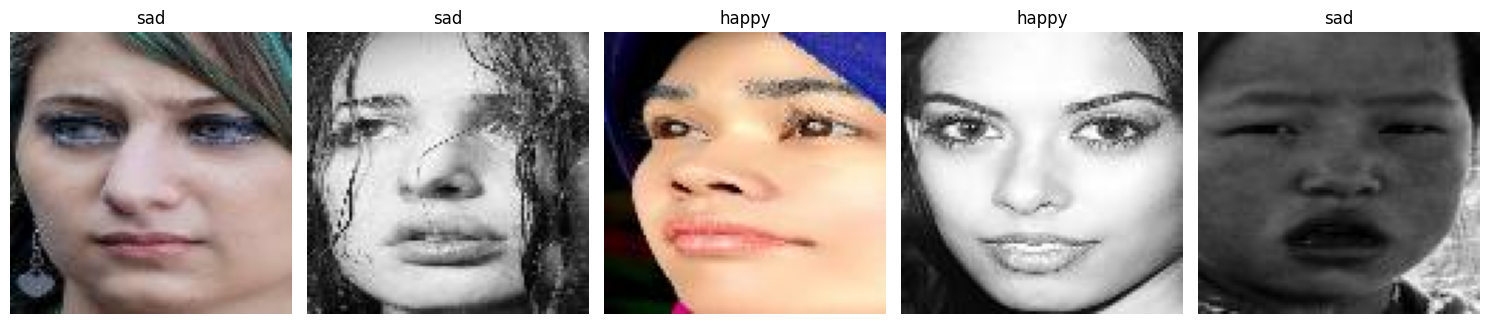

In [12]:
images = df['file_path'].head(5)

plt.figure(figsize=(15, 5))
for i, img_path in enumerate(images):
    img = cv2.imread(img_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(df['emotion_label'][i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Download and set Deepface model

In [13]:
# 2. Define a fast preprocessing function
# The model expects input shape: (48, 48, 1) and values normalized between 0-1
def preprocess_for_emotion(img_path):

      # Load image in grayscale (0 flag)
      img = cv2.imread(img_path)


      return img

# 3. Prepare the Data
# Assuming df contains your 'file_paths'
print("Preprocessing images...")

# Apply preprocessing to all images
image_data = df['file_path'].apply(preprocess_for_emotion)

image_data = np.array(image_data.tolist())
print("image data shape: ", image_data.shape)

Preprocessing images...
image data shape:  (12271, 100, 100, 3)


In [25]:
# build the model independent of the other structure
emotion_model = DeepFace.build_model(task="facial_attribute", model_name="Emotion")
emotion_model.predict(image_data[0])

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

correct label: sad
predicted labe: neutral



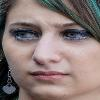

In [26]:
results = DeepFace.analyze(image_data[0], enforce_detection=False,  actions=['emotion'])
print(f'correct label: {df['emotion_label'][0]}\npredicted labe: {results[0]['dominant_emotion']}\n')
cv2_imshow(image_data[0])

In [27]:
#run on the whole dataset (takes 11 mins on cpu for training split)
results = DeepFace.analyze(image_data, enforce_detection=False,  actions=['emotion'])

KeyboardInterrupt: 

In [ ]:
len(results)

12271

In [ ]:
#this cell saves the output of the model to your drive, incase you want to load it later
def convert_numpy_floats(obj):
    """
    Recursively converts numpy float32 objects to standard Python floats
    within dictionaries and lists.
    """
    if isinstance(obj, dict):
        return {k: convert_numpy_floats(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_floats(elem) for elem in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

# Define the output file path
output_dir = '/content/drive/MyDrive/drive_bys/'
output_filename = 'deepface_results.json'
output_filepath = os.path.join(output_dir, output_filename)

# Convert numpy.float32 to standard floats before saving
serializable_results = convert_numpy_floats(results)

# Save the results to a JSON file
with open(output_filepath, 'w') as f:
    json.dump(serializable_results, f, indent=4)

print(f"Results saved to: {output_filepath}")

Results saved to: /content/drive/MyDrive/drive_bys/deepface_results.json


In [ ]:
results = json.load(open('/content/drive/MyDrive/drive_bys/deepface_results.json'))
len(results)

12271

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Define the exact order DeepFace uses (based on your output)
emotion_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# 2. Extract Probabilities from DeepFace Results
# results is the list of lists returned by DeepFace.analyze
# We divide by 100 because DeepFace returns 0-100, but sklearn expects 0-1
y_pred_proba = []

# Iterate through the results corresponding to your dataframe rows
for entry in results:
    # entry is a list of dicts (one per face). We take the first face [0].
    emotions_dict = entry[0]['emotion']

    # Extract values in the specific order
    probs = [emotions_dict[label] for label in emotion_order]
    y_pred_proba.append(probs)

# Convert to numpy array and normalize to 0-1 range
y_pred_proba = np.array(y_pred_proba) / 100.0

# 3. Prepare Ground Truth
# Map string labels from dataframe to integers (0-6) based on emotion_order
le = LabelEncoder()
le.fit(emotion_order) # Force the encoder to use our specific order
y_true = le.transform(df['emotion_label']) # Transform your DF labels

# Get hard predictions (Top-1 class index)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Probability Matrix Shape: {y_pred_proba.shape}")

Probability Matrix Shape: (12271, 7)


In [ ]:
# --- 1. Top-1 Accuracy ---
top1_acc = top_k_accuracy_score(y_true, y_pred_proba, k=1)

# --- 2. Top-3 Accuracy ---
top3_acc = top_k_accuracy_score(y_true, y_pred_proba, k=3)

# --- 3. F1 Score ---
# "Macro" gives equal weight to all classes (good for checking performance on rare emotions like disgust)
# "Weighted" accounts for class imbalance
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Per-class F1 breakdown
report = classification_report(y_true, y_pred, target_names=emotion_order)

print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print("-" * 30)
print("Per-Class Report:\n", report)

Top-1 Accuracy: 0.3872
Top-3 Accuracy: 0.6503
F1 Score (Macro): 0.2171
------------------------------
Per-Class Report:
               precision    recall  f1-score   support

       angry       0.24      0.43      0.31       705
     disgust       0.18      0.01      0.02       717
        fear       0.04      0.13      0.06       281
       happy       0.75      0.75      0.75      4772
         sad       0.25      0.16      0.19      2524
    surprise       0.04      0.01      0.01      1982
     neutral       0.12      0.31      0.17      1290

    accuracy                           0.39     12271
   macro avg       0.23      0.26      0.22     12271
weighted avg       0.39      0.39      0.37     12271



In [ ]:
def compute_ece(y_true, y_pred_proba, n_bins=10):
    """
    Computes Expected Calibration Error (ECE) for multi-class classification.

    Args:
        y_true (array): True integer labels (N,)
        y_pred_proba (array): Predicted probabilities (N, C)
        n_bins (int): Number of bins for calibration
    """
    # 1. Get the max probability (confidence) and the predicted class for each sample
    confidences = np.max(y_pred_proba, axis=1)
    predictions = np.argmax(y_pred_proba, axis=1)

    # 2. Check correctness
    accuracies = (predictions == y_true)

    # 3. Define bin boundaries (0.0 to 1.0)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    ece = 0.0
    total_samples = len(y_true)

    for i in range(n_bins):
        # Find samples that fall into this confidence bin
        lower = bin_boundaries[i]
        upper = bin_boundaries[i + 1]

        # Mask for samples in this bin
        in_bin = (confidences > lower) & (confidences <= upper)
        prop_in_bin = np.mean(in_bin) # Proportion of samples in this bin

        if prop_in_bin > 0:
            # Accuracy in this bin: mean(correctness)
            accuracy_in_bin = np.mean(accuracies[in_bin])

            # Confidence in this bin: mean(confidence)
            confidence_in_bin = np.mean(confidences[in_bin])

            # Absolute difference * weight
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin

    return ece

# Calculate ECE
ece_score = compute_ece(y_true, y_pred_proba, n_bins=15)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.4350


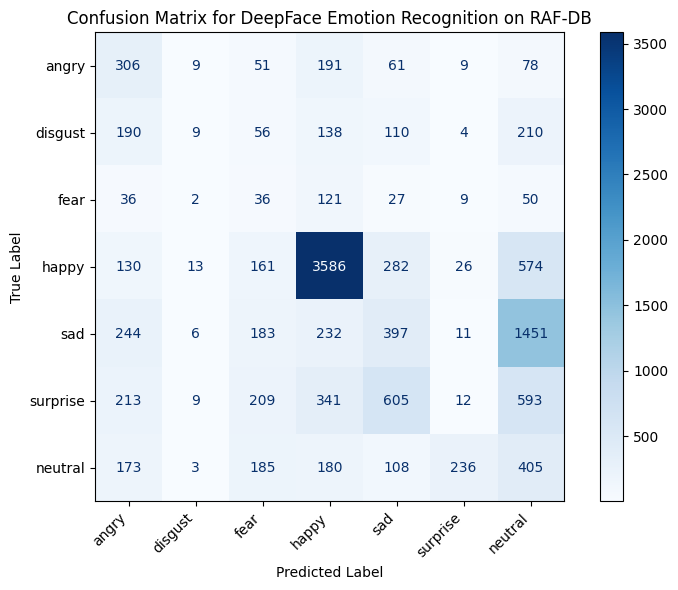

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get display labels (emotion_order is already defined in the notebook)
display_labels = emotion_order

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for DeepFace Emotion Recognition on RAF-DB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

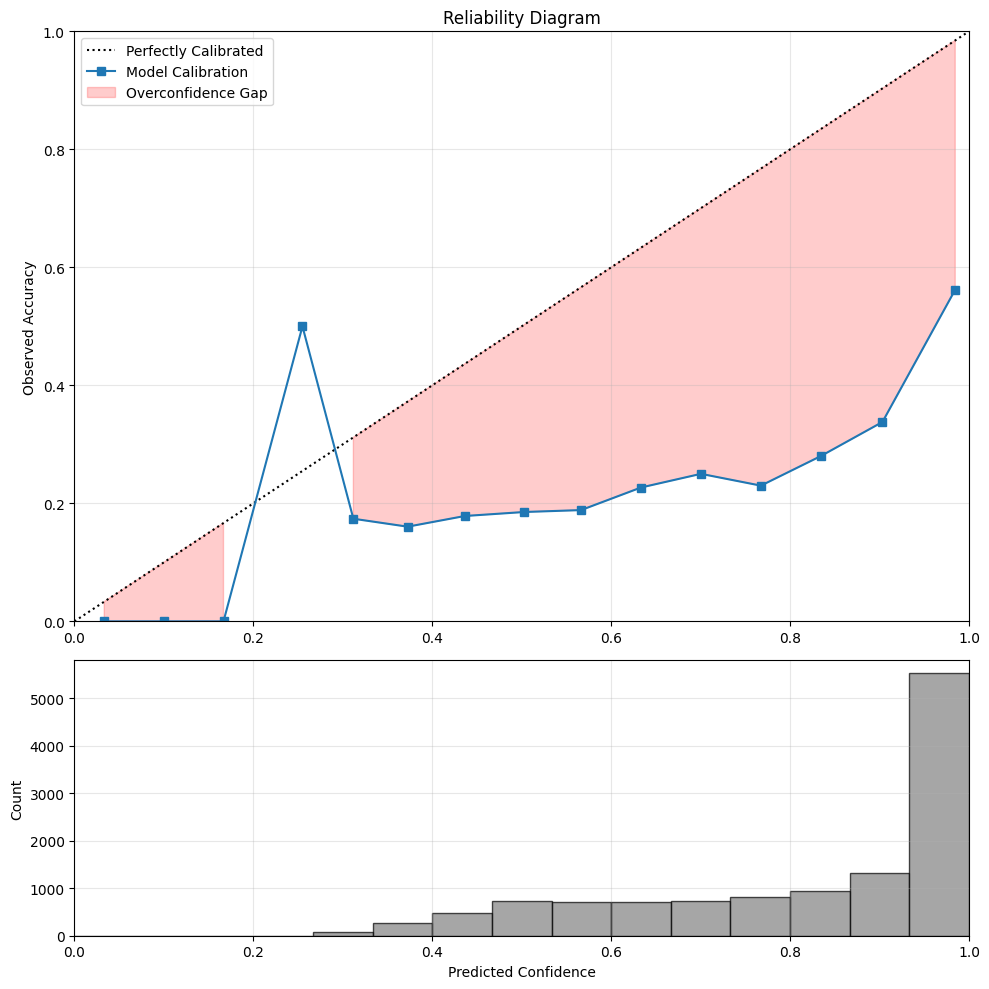

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_diagram(y_true, y_prob, n_bins=15, title="Reliability Diagram"):
    """
    Plots a multiclass reliability diagram.

    Args:
        y_true: Array of true class indices (0..N).
        y_prob: Array of predicted probabilities (N_samples, N_classes).
        n_bins: Number of bins for the calibration curve.
    """
    # 1. Get the Confidence (max prob) and Prediction for each sample
    confidences = np.max(y_prob, axis=1)
    predictions = np.argmax(y_prob, axis=1)

    # 2. Determine if prediction was correct
    accuracies = (predictions == y_true)

    # 3. Create Bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for i in range(n_bins):
        # Define bin range
        lower, upper = bin_boundaries[i], bin_boundaries[i+1]

        # Find samples in this bin
        in_bin = (confidences > lower) & (confidences <= upper)
        count = np.sum(in_bin)
        bin_counts.append(count)

        if count > 0:
            # Calculate average accuracy and confidence for this bin
            bin_accuracies.append(np.mean(accuracies[in_bin]))
            bin_confidences.append(np.mean(confidences[in_bin]))
        else:
            bin_accuracies.append(0)
            bin_confidences.append((lower + upper) / 2)

    # --- PLOTTING ---
    plt.figure(figsize=(10, 10))

    # Subplot 1: The Reliability Curve
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    # Perfect calibration line (Diagonal)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    # The Model's curve
    ax1.plot(bin_confidences, bin_accuracies, "s-", label="Model Calibration")

    # Fill areas to highlight over/under confidence
    ax1.fill_between(bin_confidences, bin_confidences, bin_accuracies,
                     where=np.array(bin_accuracies) < np.array(bin_confidences),
                     color='red', alpha=0.2, label="Overconfidence Gap")

    ax1.set_ylabel("Observed Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, 1])
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Confidence Histogram (How many samples in each bin?)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax2.hist(confidences, bins=bin_boundaries, alpha=0.7, color='gray', edgecolor='black')
    ax2.set_xlabel("Predicted Confidence")
    ax2.set_ylabel("Count")
    ax2.set_xlim([0, 1])
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- USAGE ---
# y_true_indices: your integer ground truth (from previous step)
# y_pred_proba: your probability matrix (from previous step)

plot_reliability_diagram(y_true, y_pred_proba, n_bins=15)

# **GRAD-CAM EXPERIMENT SECTION**

We apply Grad-CAM (Gradient-weighted Class Activation Mapping) to the DeepFace emotion
model trained on facial expressions. The goal is to understand **which regions of the face**
(eyes, mouth, etc.) the model uses to classify different emotions.

## Imports

In [59]:
from deepface import DeepFace
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

## DeepFace model setup

In [68]:
# Build deepface EmotionClient and extract the underlying keras model
emotion_client = DeepFace.build_model(task="facial_attribute", model_name="Emotion")
print(type(emotion_client))

<class 'deepface.models.demography.Emotion.EmotionClient'>


In [69]:
base_model = emotion_client.model # it is a sequential model
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 44, 44, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 7, 7, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 1, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,485,831 (5.67 MB)

 Trainable params: 1,485,831 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

Next, we build a functional model for Grad-CAM by replaying base_model layers on a new INput tensor, while remembering the last conv like activation.

In [70]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D

gc_input = tf.keras.Input(shape=(48, 48, 1))

x = gc_input
target_activation = None  # will store activation of last conv-like layer

for layer in base_model.layers:
    x = layer(x)
    # If this layer is conv like then record its output as the Grad-CAM target
    if isinstance(layer, (Conv2D, DepthwiseConv2D, SeparableConv2D)):
        target_activation = x


Grad-CAM model

In [ ]:
# final output of the model
gc_output = x

gradcam_model = tf.keras.Model(inputs=gc_input,
                               outputs=[target_activation, gc_output])

In [79]:
# Sanity check with a summy input
dummy = tf.zeros((1, 48, 48, 1), dtype=tf.float32)
fmaps, preds = gradcam_model(dummy)

print("Feature map shape:", fmaps.shape)
print("Preds shape:", preds.shape)

Feature map shape: (1, 3, 3, 128)
Preds shape: (1, 7)


In [46]:
dummy_input = tf.zeros((1, 48, 48, 1), dtype=tf.float32)
_ = base_model(dummy_input)

## Preprocess RAF images for the emotion model

For GRAD-CAM we need to feed images in exactly the format the model expects


*   Grayscale faces
*   48x48 resolution

*   Normalized pixel values ([0,1])
*   Iput shape (1,48,48,1) - (batch, height, width, channel)

We will therefore convert the RAF-DB aligned BGR images to this format before feeding them into the Grad-CAM pipeline.





In [72]:
import cv2
import numpy as np

def preprocess_for_emotion(img_bgr):
    """
    Convert RAF aligned face image into a tensor of shape
     (1, 48, 48, 1) for the emotion model.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Resize to 48x48
    resized = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)

    # Normalize to [0,1]
    norm = resized.astype("float32") / 255.0

    # Add channel + batch dims: (1, 48, 48, 1)
    tensor = norm.reshape(1, 48, 48, 1)

    return tensor


In [73]:
#
image_data = df['file_path'].apply(lambda p: cv2.imread(p))
image_data = np.array(image_data.tolist())  # (N, H, W, 3), BGR

## Implementation of Grad-CAM

### Grad-CAM on DeepFace Emotion Model

Given a CNN and a target class $c$ (e.g., "happy"), Grad-CAM operates on the **last
convolutional feature maps** $A^k$ (where $k$ indexes channels) and the class
score $y^c$ (the logit or pre-softmax value for class $c$).

Formally, let the preprocessed input be
$$
x \in \mathbb{R}^{1 \times 48 \times 48 \times 1}.
$$

1. **Forward pass**

   We run a forward pass through `gradcam_model` to obtain:

   - $A^k$: feature maps from the last convolutional layer
   - $y^c$: class scores for all emotion classes

2. **Select target class**

   We choose the target class $c$ either as:
   - the predicted class $c = \arg\max y$, or  
   - a manually specified class index.

3. **Gradients w.r.t. feature maps**

   Using automatic differentiation (`tf.GradientTape`), we compute the gradient
   of the target class score with respect to each feature map:

   $$
   \frac{\partial y^c}{\partial A^k_{ij}} \, .
   $$

4. **Channel importance weights**

   We spatially average these gradients over the feature map to obtain a single
   **importance weight** $\alpha_k^c$ per channel:

   $$
   \alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}
   $$

   where $Z$ is the number of spatial locations (height $\times$ width).

5. **Grad-CAM map**

   We then form the Grad-CAM map as a weighted sum of the feature maps,
   followed by a ReLU to keep only positive contributions:

   $$
   L_{\text{Grad-CAM}}^c = \mathrm{ReLU}\left( \sum_k \alpha_k^c A^k \right).
   $$

6. **Normalization and upsampling**

   Finally, we normalize $L_{\text{Grad-CAM}}^c$ to the range $[0,1]$ and
   upsample it to the original image resolution to obtain a **heatmap**
   showing which pixels contribute most to class $c$.

In our project, we apply this procedure to a subset of RAF-DB samples to inspect how
DeepFace’s internal attention patterns relate to facial regions (eyes, mouth, etc.)
and to known differences in neurodivergent expression (e.g., reduced eye contact,
flatter affect).


In [74]:
def make_gradcam_heatmap(img_tensor, class_index=None):
    """
    COmputes the Grad-CAM heatmap for an input image.

    Args:
      img_tensor: (1, 48, 48, 1)
      class_index: target class index or None (then predicted class is used)

    Returns:
        heatmap: (H, W) numpy array in [0,1]
        preds:   1D numpy array of model predictions for all classes
    """
    img_tensor = tf.cast(img_tensor, tf.float32)

    with tf.GradientTape() as tape:
        # Forward pass
        conv_outputs, predictions = gradcam_model(img_tensor, training=False)

        # If no class_index is provided use predicted class
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]  # scalar


    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)   # (1, H, W, C)


    #Global average pool the gradients over spatial dimensions
    #This givesone importance weight per channel
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))   # (1, C)

    conv_outputs = conv_outputs[0]  # (H, W, C)
    pooled_grads = pooled_grads[0]  # (C,)


    # Compute weighted sum over channels
    weighted_sum = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)
    for i in range(conv_outputs.shape[-1]):
        weighted_sum += pooled_grads[i] * conv_outputs[:, :, i]


    # Apply ReLU (to keep only positive contributions)
    heatmap = tf.nn.relu(weighted_sum)


    # Normalize
    heatmap -= tf.reduce_min(heatmap)
    max_val = tf.reduce_max(heatmap)
    if max_val > 0:
        heatmap /= max_val

    return heatmap.numpy(), predictions.numpy()[0]

# Visualizing Grad-CAM on RAF images

We now apply Grad-CAM to RAF-DB samples. For each image:

1. We load the pre-aligned BGR face from RAF-DB.
2. We preprocess it to (1, 48, 48, 1) for the emotion model.
3. We compute the Grad-CAM heatmap.
4. We upsample the heatmap to the original image size and overlay it
   with a color map to highlight important regions.

This gives a qualitative view of which facial regions (eyes, mouth, nose etc.)
the model uses to classify different emotions.

### Overlay + example visualization


In [75]:
import matplotlib.pyplot as plt

# already loaded the RAF images as BGR images

def overlay_gradcam(img_bgr, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    img_bgr: original BGR face (H, W, 3)
    heatmap: 2D array (h, w) in [0, 1]
    """
    # Resize heatmap to match original image resolution
    heatmap_resized = cv2.resize(heatmap, (img_bgr.shape[1], img_bgr.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Apply colormap
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)

    # BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Blend original and heatmap
    overlay = cv2.addWeighted(img_rgb, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

### Run on one sample

True RAF label: sad
Predicted: neutral (idx: 6 )
Probs: {'angry': np.float32(0.017), 'disgust': np.float32(0.0), 'fear': np.float32(0.005), 'happy': np.float32(0.001), 'sad': np.float32(0.253), 'surprise': np.float32(0.0), 'neutral': np.float32(0.724)}


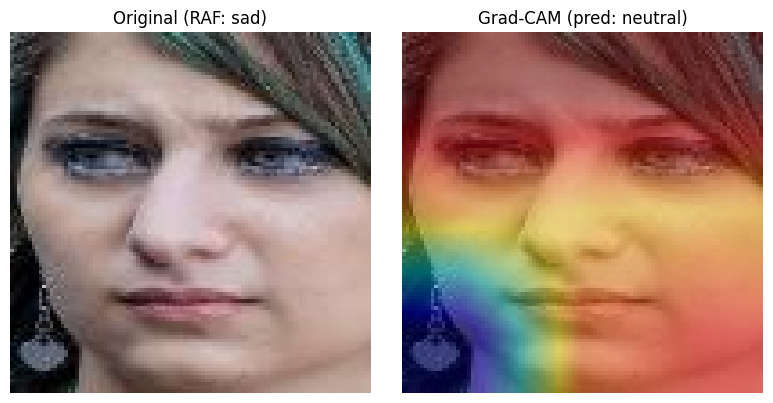

In [76]:
idx = 0  #
img_bgr = image_data[idx]
true_label = df['emotion_label'].iloc[idx]

img_tensor = preprocess_for_emotion(img_bgr)
heatmap, preds = make_gradcam_heatmap(img_tensor)

pred_idx = np.argmax(preds)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print("True RAF label:", true_label)
print("Predicted:", emotion_labels[pred_idx], "(idx:", pred_idx, ")")
print("Probs:", dict(zip(emotion_labels, np.round(preds, 3))))

overlay_img = overlay_gradcam(img_bgr, heatmap)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original (RAF: {true_label})")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (pred: {emotion_labels[pred_idx]})")
plt.imshow(overlay_img)
plt.axis("off")

plt.tight_layout()
plt.show()

## Visualizing Grad-CAM for multiple RAF samples

In [77]:
import os
import matplotlib.pyplot as plt

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

os.makedirs("gradcam_outputs", exist_ok=True)

def show_and_save_gradcam(idx, save=True):
    img_bgr = image_data[idx]
    true_label = df['emotion_label'].iloc[idx]

    # preprocess and compute Grad-CAM
    img_tensor = preprocess_for_emotion(img_bgr)

    # heatmap + predictions
    heatmap, preds = make_gradcam_heatmap(img_tensor)
    pred_idx = np.argmax(preds)
    pred_label = emotion_labels[pred_idx]

    overlay_img = overlay_gradcam(img_bgr, heatmap)

    print(f"Index: {idx}")
    print(f"True RAF label: {true_label}")
    print(f"Predicted: {pred_label} (idx: {pred_idx})")
    print("Probs:", dict(zip(emotion_labels, [float(f"{p:.3f}") for p in preds])))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original\nRAF: {true_label}")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM\nPred: {pred_label}")
    plt.imshow(overlay_img)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    if save:
        fname = f"gradcam_{idx}_true-{true_label}_pred-{pred_label}.png"
        cv2.imwrite(os.path.join("gradcam_outputs", fname),
                    cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR))


Index: 0
True RAF label: sad
Predicted: neutral (idx: 6)
Probs: {'angry': 0.017, 'disgust': 0.0, 'fear': 0.005, 'happy': 0.001, 'sad': 0.253, 'surprise': 0.0, 'neutral': 0.724}


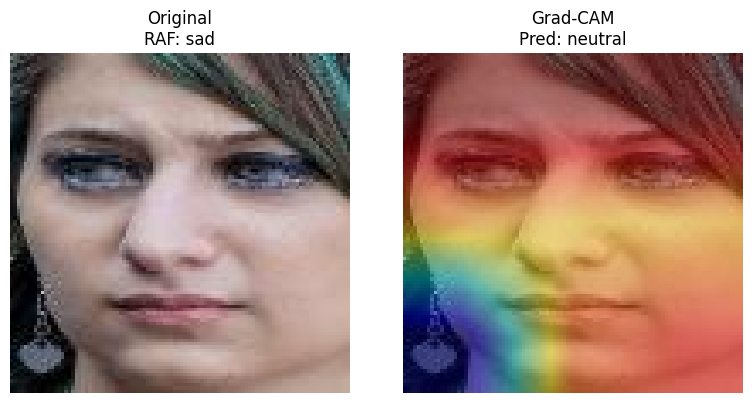

Index: 5
True RAF label: surprise
Predicted: neutral (idx: 6)
Probs: {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.402, 'sad': 0.104, 'surprise': 0.0, 'neutral': 0.494}


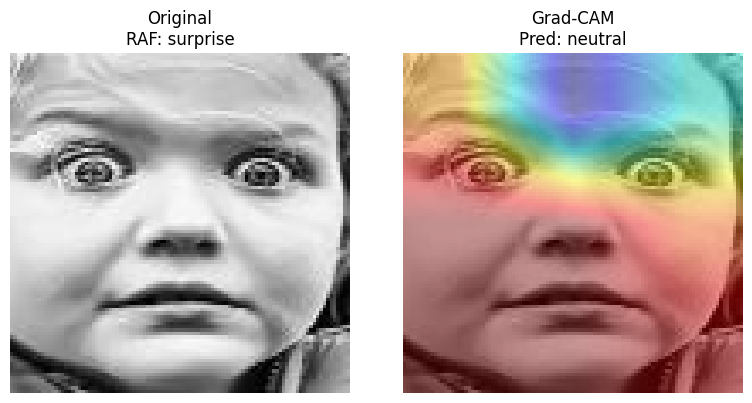

Index: 10
True RAF label: happy
Predicted: neutral (idx: 6)
Probs: {'angry': 0.001, 'disgust': 0.0, 'fear': 0.053, 'happy': 0.28, 'sad': 0.002, 'surprise': 0.006, 'neutral': 0.659}


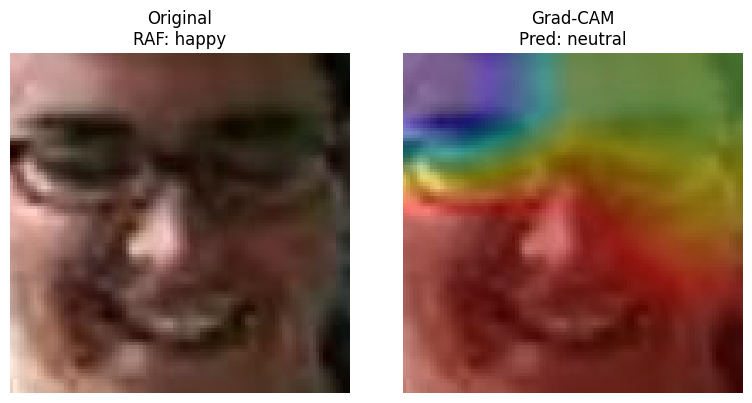

Index: 25
True RAF label: sad
Predicted: fear (idx: 2)
Probs: {'angry': 0.027, 'disgust': 0.0, 'fear': 0.726, 'happy': 0.045, 'sad': 0.012, 'surprise': 0.0, 'neutral': 0.189}


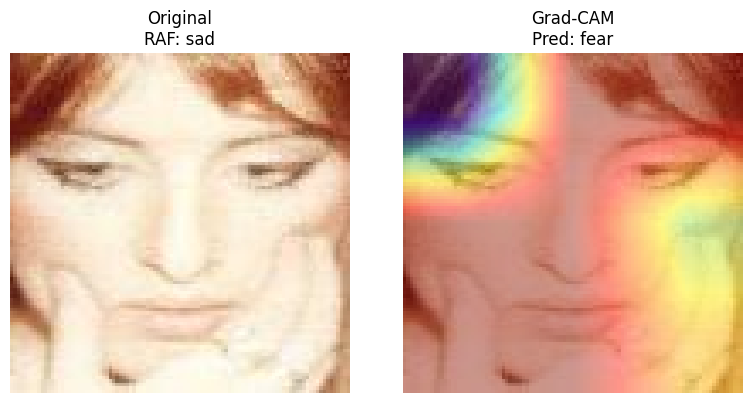

Index: 40
True RAF label: sad
Predicted: surprise (idx: 5)
Probs: {'angry': 0.019, 'disgust': 0.0, 'fear': 0.086, 'happy': 0.119, 'sad': 0.0, 'surprise': 0.775, 'neutral': 0.002}


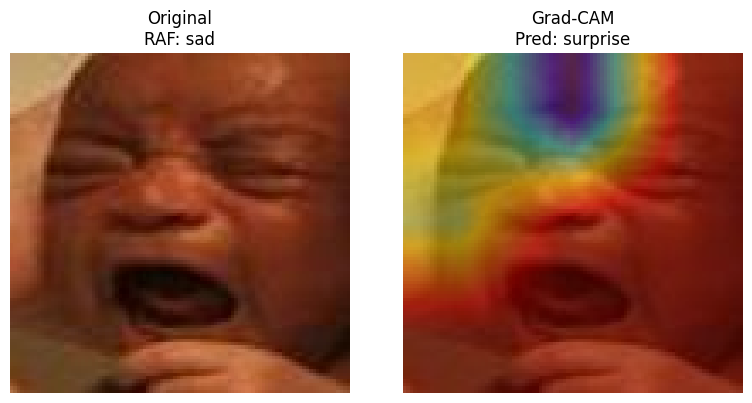

In [78]:
for idx in [0, 5, 10, 25, 40]:
    show_and_save_gradcam(idx)

## **Aggregated Grad-CAM Analysis (Beyond Single Images)**

### **Per-emotion Average Grad-CAM Heatmaps**

### Per-emotion Average Grad-CAM Heatmaps

Single Grad-CAM maps are useful but noisy. To capture **systematic patterns**, we compute an **average Grad-CAM heatmap per emotion**.

For each image in a subset:

1. We compute the Grad-CAM heatmap $H^{(n)}$ for the model's **predicted** class.
2. We group heatmaps by predicted emotion (e.g., "happy", "sad").
3. For each emotion \( e \), we compute the **mean heatmap**:

$$
\bar{H}_e = \frac{1}{N_e} \sum_{n \in \mathcal{I}_e} H^{(n)}
$$

where:
- $ \mathcal{I}_e $ is the set of indices whose predicted label is $e$,  
- $ N_e = |\mathcal{I}_e| $ is the number of samples in that set.  

TThe resulting $ \bar{H}_e $ shows the canonical attention pattern for emotion $e$ (for example, a mouth-centric pattern for "happy").

In [103]:
import numpy as np

N_SAMPLES = 200
np.random.seed(0)

subset_indices = np.random.choice(len(image_data),
                                  size=N_SAMPLES,
                                  replace=False)

len(subset_indices)

200

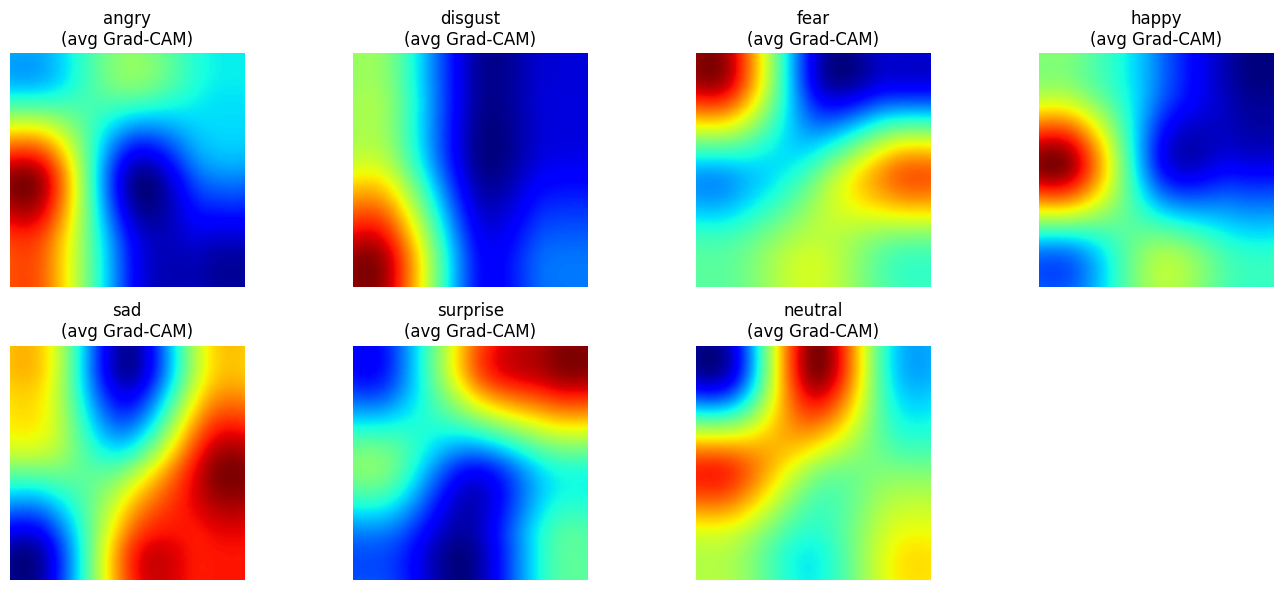

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# store heatmaps per predicted emotion
per_emotion_heatmaps = defaultdict(list)

# loop over the subset for Grad-CAM aggregation
for idx in subset_indices:
    img_bgr = image_data[idx]
    img_tensor = preprocess_for_emotion(img_bgr)


    heatmap, preds = make_gradcam_heatmap(img_tensor)
    pred_idx = np.argmax(preds)
    pred_label = emotion_labels[pred_idx]

    per_emotion_heatmaps[pred_label].append(heatmap)

# compute average heatmaps per emotion
avg_heatmaps = {}
for label, hmaps in per_emotion_heatmaps.items():
    hmaps_arr = np.stack(hmaps, axis=0)   # (N_e, h, w)
    avg_heatmaps[label] = np.mean(hmaps_arr, axis=0)  # (h, w)

# visualize per-emotion average heatmaps
plt.figure(figsize=(14, 6))

plot_labels = emotion_labels  # order of plottin

for i, label in enumerate(plot_labels):
    if label not in avg_heatmaps:
        continue  #

    avg_hmap = avg_heatmaps[label]

    # upscale to a larger size for visualization only
    vis_hmap = cv2.resize(avg_hmap, (128, 128), interpolation=cv2.INTER_CUBIC)
    vis_hmap_norm = (vis_hmap - vis_hmap.min()) / (vis_hmap.max() - vis_hmap.min() + 1e-8)

    plt.subplot(2, 4, i + 1)
    plt.title(f"{label}\n(avg Grad-CAM)")
    plt.imshow(vis_hmap_norm, cmap='jet')
    plt.axis("off")

plt.tight_layout()
plt.show()


### **Region-level atention**

Grad-CAM heatmaps $H \in \mathbb{R}^{H \times W}$
 capture where the model looks,
but we need want **numeric** summaries.

We define approximate regions on the face (eyes, mouth, nose/center, other)
using fixed relative coordinates, assuming RAF-DB aligned faces.

Given a resized heatmap \( H \) over the original image resolution, let:

- $R_{\text{eyes}}$ = set of pixels in the eyes region  
- $R_{\text{mouth}}$ = set of pixels in the mouth region  
- $R_{\text{nose}}$ = set of pixels in a central band (nose/center)  
- $R_{\text{other}}$ = all remaining pixels  


We define the **attention fraction** for each region as:

$$
f_{\text{region}} = \frac{\sum_{(i,j) \in R_{\text{region}}} H_{ij}}
                         {\sum_{i,j} H_{ij}}
$$

These fractions satisfy:

$$
f_{\text{eyes}} + f_{\text{mouth}} + f_{\text{nose}} + f_{\text{other}} = 1
$$

By aggregating these fractions per emotion, we can say, for example:

- "On average, 65% of 'happy' attention is on the mouth region,"
- "For 'sad', attention shifts to the eye region,"
- etc.

This forms a quantitative link between model behavior and neurotypical facial
expression patterns (e.g., strong mouth-based happiness).


The following cell defines region definitions on the face.

In [106]:
def get_face_regions(img_bgr):
    """
    Return approximate regions for eyes, mouth, and nose/center.

    Args:
        img_bgr: BGR image of shape (H, W, 3)

    Returns:
        dict: region_name -> (x1, y1, x2, y2)
    """
    h, w, _ = img_bgr.shape

    # Eyes: upper-middle band
    eye_y1 = int(0.2 * h)
    eye_y2 = int(0.4 * h)
    eye_x1 = int(0.2 * w)
    eye_x2 = int(0.8 * w)

    # Mouth: lower band
    mouth_y1 = int(0.6 * h)
    mouth_y2 = int(0.85 * h)
    mouth_x1 = int(0.25 * w)
    mouth_x2 = int(0.75 * w)

    # Nose / center region
    nose_y1 = int(0.35 * h)
    nose_y2 = int(0.65 * h)
    nose_x1 = int(0.35 * w)
    nose_x2 = int(0.65 * w)

    regions = {
        "eyes":  (eye_x1,  eye_y1,  eye_x2,  eye_y2),
        "mouth": (mouth_x1, mouth_y1, mouth_x2, mouth_y2),
        "nose":  (nose_x1,  nose_y1,  nose_x2,  nose_y2),
    }
    return regions


This will compute region fractions for one sample.

In [107]:
def compute_region_fractions(img_bgr, heatmap):
    """
    Compute attention fractions for eyes, mouth, nose, and other
    based on a Grad-CAM heatmap and the original image.

    Args:
        img_bgr: (H, W, 3) BGR image
        heatmap: 2D array (h, w) with values >= 0 (Grad-CAM output)

    Returns:
        dict with keys: eyes, mouth, nose, other
    """
    H_img, W_img, _ = img_bgr.shape


    heatmap_resized = cv2.resize(heatmap, (W_img, H_img), interpolation=cv2.INTER_LINEAR)

    # ensure non-negative
    heatmap_resized = np.maximum(heatmap_resized, 0.0)
    total = heatmap_resized.sum() + 1e-8  #

    regions = get_face_regions(img_bgr)

    region_sums = {}
    for name, (x1, y1, x2, y2) in regions.items():
        region_patch = heatmap_resized[y1:y2, x1:x2]
        region_sums[name] = float(region_patch.sum())

    # "other" region = everything not in eyes/mouth/nose
    sum_known = sum(region_sums.values())
    other_sum = float(total - sum_known)

    # convert to fractions
    fractions = {name: val / total for name, val in region_sums.items()}
    fractions["other"] = other_sum / total

    return fractions


We now build a datafram with regions fractions per sample

In [108]:
import pandas as pd

records = []

for idx in subset_indices:
    img_bgr = image_data[idx]
    true_label = df["emotion_label"].iloc[idx]

    # Grad-CAM
    img_tensor = preprocess_for_emotion(img_bgr)
    heatmap, preds = make_gradcam_heatmap(img_tensor)
    pred_idx = np.argmax(preds)
    pred_label = emotion_labels[pred_idx]

    # region attention fractions
    fracs = compute_region_fractions(img_bgr, heatmap)

    records.append({
        "idx": idx,
        "true_label": true_label,
        "pred_label": pred_label,
        "correct": int(true_label == pred_label),
        "eyes_frac": fracs["eyes"],
        "mouth_frac": fracs["mouth"],
        "nose_frac": fracs["nose"],
        "other_frac": fracs["other"],
    })

attention_df = pd.DataFrame(records)
attention_df.head()

,idx,true_label,pred_label,correct,eyes_frac,mouth_frac,nose_frac,other_frac
0,6398,happy,happy,1,0.148196,0.143028,0.068747,0.640029
1,11170,neutral,neutral,1,0.216620,0.071277,0.139825,0.572278
2,10529,neutral,sad,0,0.005660,0.291720,0.038519,0.664100
3,1466,surprise,neutral,0,0.084845,0.095314,0.045683,0.774157
4,3448,happy,happy,1,0.228833,0.076937,0.163694,0.530536


In [109]:
# average attention fractions per predicted emotion
avg_by_pred = (
    attention_df
    .groupby("pred_label")[["eyes_frac", "mouth_frac", "nose_frac", "other_frac"]]
    .mean()
)

avg_by_pred


,eyes_frac,mouth_frac,nose_frac,other_frac
pred_label,,,,
angry,0.118395,0.102677,0.077408,0.701519
disgust,0.054558,0.114529,0.029739,0.801173
fear,0.100132,0.134972,0.086274,0.678621
happy,0.112198,0.129846,0.083502,0.674453
neutral,0.137069,0.114054,0.094262,0.654616
sad,0.094370,0.141784,0.081537,0.682309
surprise,0.141652,0.069729,0.064944,0.723675


<Figure size 1000x500 with 0 Axes>

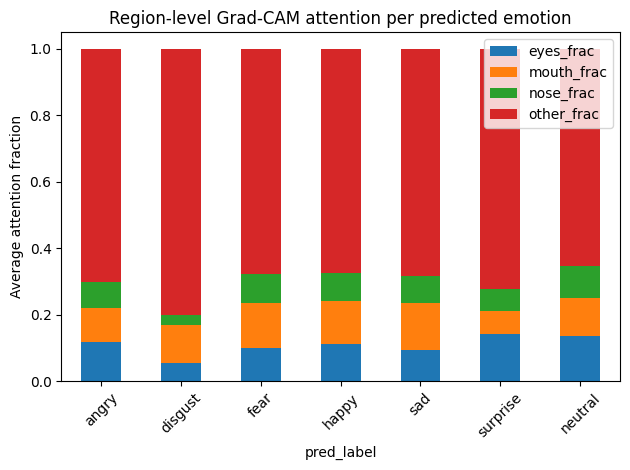

In [110]:
import matplotlib.pyplot as plt

avg_by_pred_plot = avg_by_pred.reindex(emotion_labels)  #

plt.figure(figsize=(10, 5))
avg_by_pred_plot.plot(kind="bar", stacked=True)
plt.ylabel("Average attention fraction")
plt.title("Region-level Grad-CAM attention per predicted emotion")
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Results analysis**

We used the DeepFace emotion model directly and attached a Grad-CAM pipeline to
its last convolutional layer. For each RAF-DB image, we fed the aligned face through the same preprocessing as DeepFace’s emotion pipeline, obtained the model’s predicted emotion, and then computed the gradient of that class score with respect to the feature maps of the last conv layer. We averaged these gradients to get channel-wise importance weights, we then combined them with the feature maps, and applied ReLU to obtain a class-specific importance map. Then after up sampling this to the input resolution and overlaying it on the original face, we obtained heatmaps that show which face regions the model relies on when classifying emotions.

We then compared these attention patters like for example the strong focus on
the mouth for "happy" and the heavy reliance on the eye region for some emotions, with literature on neurodivergent expression patters, such as reduced or minimal eue contact and flatter affect. this provides us with a concrete evidence that the model's internal logic is primarily alighned with neurotypical expressive normals which can be problematic, inducing bias to neurodireverse individuals.

# **References**

[1] R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra,  
“Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization,”  
in *Proc. IEEE Int. Conf. Computer Vision (ICCV)*, 2017.  
Available: https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf

[2] S. Li, W. Deng, and J. Du,  
“Reliable Crowdsourcing and Deep Locality-Preserving Learning for Expression Recognition in the Wild,”  
in *Proc. IEEE Conf. Computer Vision and Pattern Recognition (CVPR)*, 2017, pp. 2584–2593.  
(Original RAF-DB paper)  
Available: https://openaccess.thecvf.com/content_cvpr_2017/papers/Li_Reliable_Crowdsourcing_and_CVPR_2017_paper.pdf

[3] E. Barsoum, C. Zhang, C. Canton Ferrer, and Z. Zhang,  
“Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution,”  
in *Proc. 18th ACM Int. Conf. on Multimodal Interaction (ICMI)*, 2016.  
(Original FER+ paper)  
Preprint available: https://arxiv.org/abs/1608.01041

[4] Microsoft,  
“FER+: New Label Annotations for the FER2013 Dataset,”  
GitHub repository, 2016–.  
Available: https://github.com/microsoft/FERPlus

[5] S. Li, W. Deng,  
“Real-world Affective Faces Database (RAF-DB),”  
Dataset website, Beijing University of Posts and Telecommunications.  
Available: http://www.whdeng.cn/RAF/model1.html

[6] S. Serengil and A. Ozpinar,  
“DeepFace: A Lightweight Face Recognition and Facial Attribute Analysis (Age, Gender, Emotion and Race) Library for Python,”  
GitHub repository, 2017–.  
Available: https://github.com/serengil/deepface

[7] C. Guo, G. Pleiss, Y. Sun, and K. Q. Weinberger,  
“On Calibration of Modern Neural Networks,”  
in *Proc. 34th Int. Conf. on Machine Learning (ICML)*, 2017.  
(Defines Expected Calibration Error and reliability diagrams.)  
Available: https://proceedings.mlr.press/v70/guo17a/guo17a.pdf

[8] Z. Lian, Y. Li, J.-H. Tao, J. Huang, and M.-Y. Niu,  
“Expression Analysis Based on Face Regions in Real-world Conditions,”  
arXiv preprint, 2019.  
(Analyzes contribution of different face areas to different emotions, using CAM/Grad-CAM.)  
Available: https://arxiv.org/abs/1911.05188

[9] K. Kärkkäinen and J. Joo,  
“FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age,”  
in *Proc. IEEE/CVF Winter Conf. on Applications of Computer Vision (WACV)*, 2021.  
Available: https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf  
Dataset GitHub: https://github.com/joojs/fairface

[10] C. T. Keating and co-authors,  
“Facial Expression Production and Recognition in Autism Spectrum Disorders,”  
in *Child and Adolescent Psychiatric Clinics of North America*, vol. 29, no. 3, 2020, pp. 557–573.  
(Review on facial expression production/recognition in autism.)  
Available: https://www.childpsych.theclinics.com/article/S1056-4993(20)30018-3/fulltext

[11] High-Level Expert Group on Artificial Intelligence, European Commission,  
“Ethics Guidelines for Trustworthy AI,” 2019.  
Available: https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai


### Additional Web Resources

- DeepFace library documentation and examples:  
  https://github.com/serengil/deepface

- Overview of RAF-DB:  
  http://www.whdeng.cn/RAF/model1.html

- FER+ annotations and usage examples:  
  https://github.com/microsoft/FERPlus

- EU Trustworthy AI main page:  
  https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai


Authored by

*   Hassen Said Ali

*   Luwam Major Kefali
*   Hilina Fissha Woreta



